<a href="https://colab.research.google.com/github/Ambrish001/Explainable-AI/blob/main/Adversarial_Attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import the necessary packages

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2
import json
import imutils
import argparse
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import decode_predictions
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

###Function for displaying the image

In [ ]:
# Function used for displaying the images

def show_image(title,img):
  
  # Since image is read using OpenCV, the image is in BGR format
  # Whereas Matplotlib uses RGB color values, so we convert it to RGB
  
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) 
  plt.imshow(img)
  plt.grid(False)
  plt.title(title)
  plt.show()

In [ ]:
# Function for getting the index using input class label

def get_class_index(label):

  # Enter the path of json file which contains ImageNet class to label mapping 

  imgpath = os.path.join("/content/imagenet_class_index.json")

  # Load the ImageNet class mapping file as a dictionary

  with open(imgpath) as f:
    imagenetclasses = {labels[1]:int(idx) for (idx,labels) in json.load(f).items()}

  # If Input class label has its corresponding index value then
  # return the index else return None

  return imagenetclasses.get(label,None)  

### General Images Classifier using Tensorflow without adversarial attacks

In [ ]:
# Function for pre-processing the image

def preprocess_image(img):
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img = preprocess_input(img)

  # Resize the image to 224 x 224 so that pretrained ResNet50 model can be used

  img = cv2.resize(img,(224,224))

  # Expand the dimension to add the batch in the dimension

  img = np.expand_dims(img,axis=0)
  return img

args = {'image': "/content/pig.jpg"} 

In [ ]:
image = cv2.imread(args['image'])

# Make a copy of image for annotation

working_image = image.copy()

# Resize the image without disturbing aspect ratio

working_image = imutils.resize(working_image, width = 600)
original_image = preprocess_image(image)

In [ ]:
# Use a pretrained ResNet50 model on imagenet dataset, as it will take 
# huge amount of time and computational resources to train a custom model on 
# large ImageNet dataset. 

model = ResNet50(weights="imagenet")

# Predict using input image and parse top 3 predictions

prediction = model.predict(original_image)
prediction = decode_predictions(prediction, top = 3)[0]

In [ ]:
# Loop over top 3 predictions

for (i,(imagenetID,label,prob)) in enumerate(prediction):

  # Print the ImageNet class label ID of the topmost preiction

  if i==0:
    print("{} -> {}".format(label,get_class_index(label)))

  # Display the prediction with its confidence score  

  print("{}=> {}:{:.2f}%".format(i+1,label,prob*100))  

hog -> 341
1=> hog:99.97%
2=> wild_boar:0.03%
3=> piggy_bank:0.00%


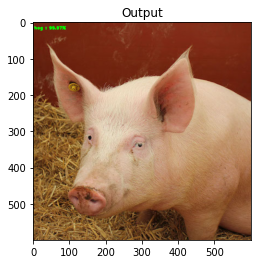

In [ ]:
# Display the image with topmost predicted label and its confidence score

caption = "{} : {:.2f}%".format(prediction[0][1],prediction[0][2]*100)
cv2.putText(working_image,caption,(3,20),cv2.FONT_HERSHEY_PLAIN,0.8,(0,255,0),2)

show_image("Output",working_image)

### Implementing Adversarial Images with Tensorflow

In [ ]:
def preprocess_adv_img(img):

  # Convert to RGB color channels, resize the image and add batch dimension

  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(224,224))
  img = np.expand_dims(img,axis=0)

  return img

In [ ]:
# Function for clipping the value of tensor in a given range by epsilon 

def clip_epsilon(tensor,epsilon):
  return tf.clip_by_value(tensor,clip_value_min=-epsilon,clip_value_max=epsilon)

In [ ]:
# Function for creating noise vectors used for generating adversaries

def generate_adversaries(model, orig_img, delta, class_idx, steps = 100):
  for step in range(0,steps):

    # Record the gradients

    with tf.GradientTape() as tape:

      # Explicitly mention that the noise vector must be tracked

      tape.watch(delta)

      # Add the noise vector to original image and preprocess the result

      adversary = preprocess_input(orig_img + delta)

      # Run this image through the ResNet model 

      predictions = model(adversary,training = False)

      # Calculate the loss with respect to original class Index

      loss = -scce(tf.convert_to_tensor([class_idx]),predictions)
      if step % 10 == 0:
        print("step: {}, loss: {}...".format(step,loss.numpy()))

      # Calculate gradient of loss with respect to noise vector  

      gradients = tape.gradient(loss,delta)

      # Update the weights and clip the noise vector

      optimizer.apply_gradients([(gradients,delta)])
      delta.assign_add(clip_epsilon(delta,epsilon = EPS))
  return delta      

In [ ]:
args_a = {"input":"/content/pig.jpg","output":"adv_pig.jpg","class_idx":341}

# Define Epsilon and Learning Rate Constant

EPS = 2/255.0
LR = 0.1

In [ ]:
# Preprocess the image and make prediction using ResNet model
# Initialize the optimizer and the loss function

image = cv2.imread(args_a["input"])
image = preprocess_adv_img(image)
model = ResNet50(weights="imagenet")
optimizer = Adam(learning_rate = LR)
scce = SparseCategoricalCrossentropy()

In [ ]:
# Create a tensor of the image and initialize the noise vector

orig_img = tf.constant(image, dtype = tf.float64)
delta = tf.Variable(tf.zeros_like(orig_img),trainable=True)
delta_new = generate_adversaries(model,orig_img,delta,args_a["class_idx"])

# Create the adversarial example and squeeze the extra batch column
# Clip the values in a range and change the color channels and save the image

adv_img = (orig_img + delta_new).numpy().squeeze()
adv_img = np.clip(adv_img,0,255).astype("uint8")
adv_img = cv2.cvtColor(adv_img,cv2.COLOR_RGB2BGR)
cv2.imwrite(args_a["output"],adv_img)

step: 0, loss: -0.00031144535751082003...
step: 10, loss: -0.0052432408556342125...
step: 20, loss: -0.7702284455299377...
step: 30, loss: -7.378965854644775...
step: 40, loss: -21.5838680267334...
step: 50, loss: -39.71458435058594...
step: 60, loss: -56.43429183959961...
step: 70, loss: -70.53872680664062...
step: 80, loss: -83.10147094726562...
step: 90, loss: -95.35459899902344...


True

label: wombat confidence: 100.00%


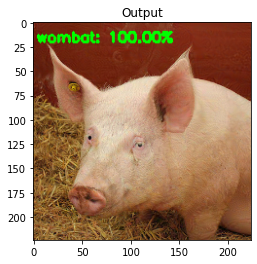

In [ ]:
# Preprocess the image

working_img = preprocess_input(orig_img + delta_new)

# Use the model to predict and parse the top 3 predictions

predictions = model.predict(working_img)
predictions = decode_predictions(predictions,top=3)[0]

# Draw the adversarial image showing the topmost predicted class and
# its respective confidence score

label = predictions[0][1]
confidence = predictions[0][2]*100
print("label: {} confidence: {:.2f}%".format(label,confidence))
text = "{}: {:.2f}%".format(label, confidence)
cv2.putText(adv_img,text,(3, 20),cv2.FONT_HERSHEY_SIMPLEX, 0.5,(0, 255, 0),2)

show_image("Output",adv_img)